In [1]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials
from array import array
import os
from PIL import Image
import sys
import time

In [2]:
def setup():
    fisier = "credentials"
    with open(fisier, "r") as f:
        lines = f.readlines()
        for line in lines:
            key, value = line.split("=")
            key = key.strip()
            os.environ[key] = value.strip()
    subscription_key = os.environ["VISION_KEY"]
    endpoint = os.environ["VISION_ENDPOINT"]
    computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))
    return computervision_client

In [3]:
computervision_client = setup()

In [4]:
img1 = open("images/test1.png", "rb")
img2 = open("images/test2.jpeg", "rb")

In [5]:
def coords_from_image(img):
    read_response = computervision_client.read_in_stream(
        image=img,
        mode="Printed",
        raw=True
    )
    
    operation_id = read_response.headers['Operation-Location'].split('/')[-1]
    while True:
        read_result = computervision_client.get_read_result(operation_id)
        if read_result.status not in ['notStarted', 'running']:
            break
        time.sleep(1)
    
    # Extract text and coordinates
    result = []
    if read_result.status == OperationStatusCodes.succeeded:
        for text_result in read_result.analyze_result.read_results:
            for line in text_result.lines:
                text = line.text
                coordinates = [point for point in line.bounding_box]
                result.append({'text': text, 'coordinates': coordinates})
    return result

In [6]:
coords_img1 = coords_from_image(img1)
coords_img2 = coords_from_image(img2)

In [7]:
print(coords_img1)

[{'text': 'Google Cloud', 'coordinates': [174.0, 53.0, 417.0, 51.0, 418.0, 93.0, 174.0, 97.0]}, {'text': 'Platform', 'coordinates': [235.0, 112.0, 349.0, 110.0, 350.0, 149.0, 235.0, 151.0]}]


In [8]:
print(coords_img1[0]['coordinates'])

[174.0, 53.0, 417.0, 51.0, 418.0, 93.0, 174.0, 97.0]


In [9]:
good_coords_img1 = {}
good_coords_img1[0] = [176.0, 42.0, 414.0, 42.0, 414.0, 105.0, 176.0, 105.0]
good_coords_img1[1] = [235.0, 113.0, 347.0, 113.0, 347.0, 150.0, 235.0, 150.0]

In [10]:
good_coords_img2 = {}
good_coords_img2[0] = [78.0, 298.0, 1330.0, 298.0, 1330.0, 461.0, 78.0, 461.0]
good_coords_img2[1] = [130.0, 583.0, 1043.0, 583.0, 1043.0, 727.0, 130.0, 727.0]
good_coords_img2[3] = [81.0, 924.0, 999.0, 924.0, 999.0, 1026.0, 81.0, 1026.0]
good_coords_img2[4] = [101.0, 1130.0, 1452.0, 1130.0, 1452.0, 1357.0, 101.0, 1357.0]

In [11]:
import matplotlib.pyplot as plt
def draw_box(coords, img):
    img = Image.open(img)
    img = img.convert("RGBA")
    for coord in coords:
        x1, y1, x2, y2, x3, y3, x4, y4 = coord['coordinates']
        x = [x1, x2, x3, x4, x1]
        y = [y1, y2, y3, y4, y1]
        plt.plot(x, y, 'r')
    plt.imshow(img)
    plt.show()

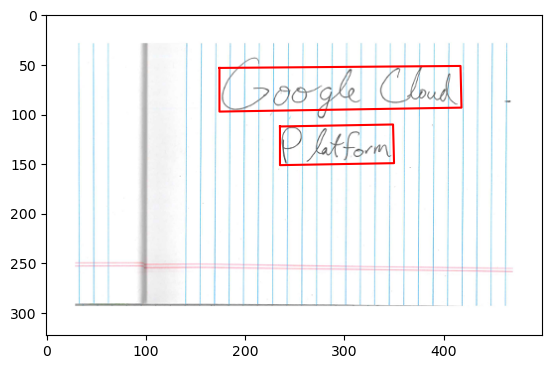

In [12]:
draw_box(coords_img1, "images/test1.png")

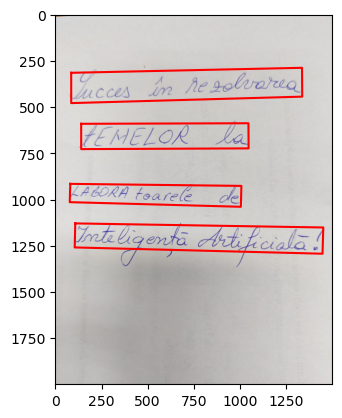

In [13]:
draw_box(coords_img2, "images/test2.jpeg")

In [14]:
import math


def box_squared_difference(box1, box2):
    x1, y1, x2, y2, x3, y3, x4, y4 = box1
    x1_, y1_, x2_, y2_, x3_, y3_, x4_, y4_ = box2
    x = [x1, x2, x3, x4]
    y = [y1, y2, y3, y4]
    x_ = [x1_, x2_, x3_, x4_]
    y_ = [y1_, y2_, y3_, y4_]
    return math.sqrt(sum([(x[i] - x_[i])**2 + (y[i] - y_[i])**2 for i in range(4)]))

In [15]:
def find_best_match(coords, good_coords):
    best_match = 0
    for i, coord in enumerate(coords):
        best_match_1 = 0
        for j, good_coord in good_coords.items():
            best_match_1 += box_squared_difference(coord['coordinates'], good_coord)
        best_match_1 /= len(good_coords)
        best_match += best_match_1
    return best_match / len(coords)

In [16]:
best_match_img1 = find_best_match(coords_img1, good_coords_img1)

In [17]:
best_match_img2 = find_best_match(coords_img2, good_coords_img2)

In [18]:
print(best_match_img1)

92.91705531725142


In [19]:
print(best_match_img2)

813.312189738173
